In [2]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import face_recognition
import numpy as np
import pandas as pd
import psycopg2


In [3]:
def buffer(face_loc):
    '''
    The buffer function refines the detected face location by 
    enlarging it so that the full face can be excracted
    '''
    top,right,bottom,left = face_loc
    h,w = [bottom-top ,right-left]
    h,w = [int(0.2*side) for side in [h,w]]

    top = max(0, top-2*h)
    bottom = min(img.shape[0], bottom+h)
    left = max(0, left-w)
    right = min(img.shape[1], right+w)
    
    return(top,right,bottom,left)


record_encoded = []
record_faces = []

# Initialise the list for the unique faces during training
unique_encoded = []
unique_faces = []

In [4]:

i = 1
path = 'Face2'
for dir in os.listdir(path):
    file = os.path.join(path,dir)
    img = cv.imread(file)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)

    faces = []
    rec_faces = []

    encode = face_recognition.face_encodings(img)
    face_locations = face_recognition.face_locations(img)

    #create the buffer for each face location and extract the face from the image
    for loc in face_locations:
        top,right,bottom,left = buffer(loc)
        face = img[top:bottom, left:right]
        faces.append(face)

    #if we have an empty list for unique faces, update it
    if len(unique_encoded)== 0:
        unique_encoded = encode
        unique_faces = faces
        print(f"INITIAL UPDATE. {len(unique_encoded)} faces")

    else:
        for n in range(0,len(encode)):
            matches = face_recognition.compare_faces(unique_encoded, encode[n],0.4)
            #if no true value is found in matches, update as unique
            if not any(matches):
                #unique_encoded.append(encode[n])
                unique_encoded = np.concatenate((unique_encoded,[encode[n]]))
                unique_faces.append(faces[n])
                print(f"MATCH UPDATE. {len(unique_encoded)} faces")

            #if any true value is found in matches, feed another separate list
            if any(matches):
                rec_faces.append(faces[n])
    #plt.imshow(img)
    print(f"{i} completed, {len(encode)} faces")
    i = i+1


INITIAL UPDATE. 2 faces
1 completed, 2 faces
MATCH UPDATE. 3 faces
MATCH UPDATE. 4 faces
MATCH UPDATE. 5 faces
2 completed, 4 faces
MATCH UPDATE. 6 faces
MATCH UPDATE. 7 faces
3 completed, 3 faces
4 completed, 2 faces


In [7]:
import psycopg2
import pandas as pd

# Assuming unique_faces and unique_encoded are available
im_byte = []
im_size = []

for face in unique_faces:
    im_byte.append(psycopg2.Binary(face.tobytes()))  # Convert face to binary format
    im_size.append(face.shape)

df = pd.DataFrame({
    'names': [None] * len(unique_faces),  # Create an empty list for the names
    'Face': im_byte,
    'image_shape': list(im_size),
    'db_face': list(unique_faces),
    'db_encode': list(unique_encoded)
})

# Connect to PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="Attendance manager",
    user="postgres",
    password="password",
    port="5432"
)

# Create a cursor
cur = conn.cursor()

# Create a table in the database (adjust SQL to your needs)
cur.execute('''
CREATE TABLE IF NOT EXISTS GeneralAttendance (
    id SERIAL PRIMARY KEY,
    name TEXT,
    Face BYTEA,  -- Store the face image as binary (BYTEA)
    image_shape TEXT,  -- Store shape as text, adjust if needed
    db_encode TEXT
)
''')

# Iterate over DataFrame rows and insert them into the table one by one
for i, row in df.iterrows():
    cur.execute(
        "INSERT INTO GeneralAttendance (name, Face, image_shape, db_encode) VALUES (%s, %s, %s, %s)",
        (row['names'], row['Face'], str(row['image_shape']), str(row['db_encode']))
    )

# Commit changes and close the connection
conn.commit()
cur.close()
conn.close()


## LIVE ATTENDANCE

In [82]:
db_record = {
    'name': [],
    'face': [],
    'face_encode' : []
}
# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="Attendance manager",
    user="postgres",
    password="password",
    port="5432"
)

# Create a cursor
cur = conn.cursor()

# Query to retrieve the binary image data and the shape
cur.execute('SELECT name, Face BYTEA, image_shape, db_encode FROM GeneralAttendance')  # Adjust to get the correct row
result = cur.fetchall()

# Close the cursor and connection
cur.close()
conn.close()


for row in result:
    db_record['name'].append(row[0]) 
    db_record['face_encode'].append(np.fromstring(row[3].strip("[]"), sep=" "))
    binary_data = row[1]  # The binary image data (BYTEA)
    image_shape = eval(row[2])  # Convert the image shape from text to tuple

    binary_data = bytes.fromhex(binary_data[2:])
    image_data = np.frombuffer(binary_data, dtype=np.uint8)
    face = image_data.reshape(image_shape)
    db_record['face'].append(face)

db_df = pd.DataFrame(db_record)



,name,face,face_encode
0,None,"[[[166, 161, 70], [137, 134, 53], [114, 111, 4...","[-0.18207389, 0.09845185, 0.14208061, -0.12798..."
1,None,"[[[21, 21, 19], [16, 16, 14], [22, 22, 20], [2...","[-0.20037054, 0.14445959, 0.0945311, -0.016889..."
2,None,"[[[126, 121, 55], [126, 121, 55], [126, 121, 5...","[-0.2448585, 0.12003864, 0.0757712, -0.0108621..."
3,None,"[[[20, 22, 19], [21, 23, 20], [22, 24, 21], [2...","[-0.22696961, 0.08611412, 0.12058324, -0.05164..."
4,None,"[[[74, 79, 47], [74, 81, 47], [76, 83, 49], [7...","[-0.17892317, 0.0670862, 0.07294105, -0.124285..."
5,None,"[[[19, 19, 17], [18, 18, 16], [17, 17, 15], [1...","[-0.171252459, 0.0703942999, 0.0516260117, -0...."
6,None,"[[[9, 13, 24], [14, 18, 29], [19, 23, 34], [22...","[-0.08739144, 0.06078542, 0.03407051, -0.06409..."


In [71]:
cleaned_string = df['db_encode'][0].replace('\n', ' ').replace('  ', ' ').strip()
array_list = ast.literal_eval(cleaned_string)
numpy_array = np.array(array_list)

print(type(numpy_array))
print()
df['db_encode'][0]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

In [93]:
import ast

face_string = df['db_face'][0]  # Assuming the data in db_face is stored as a string
face_array = ast.literal_eval(face_string)  # Safely convert the string to a Python list
im = np.array(face_array, dtype=np.uint8)  # Convert the list to a NumPy array with dtype uint8
im

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

TypeError: Image data of dtype <U629 cannot be converted to float

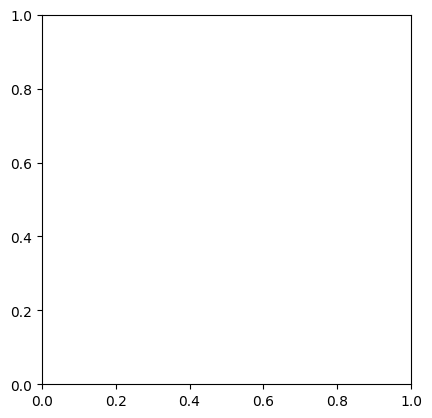

In [87]:
plt.imshow(im)

In [27]:
db_face = unique_faces
db_encode = unique_encoded

date = '01-01-2000'
dattend = np.zeros(len(db_face))

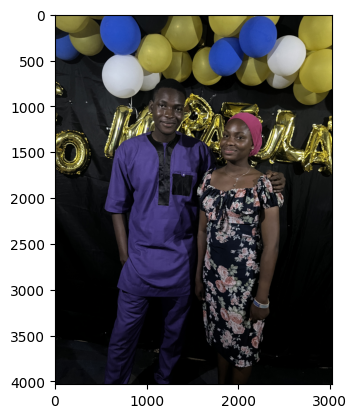

In [14]:
##  IN THE LIVE IMAGE  ##

path = 'Face2'
file = os.path.join(path,dir)
img = cv.imread(file)
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)

live_encode = face_recognition.face_encodings(img)
for enc in live_encode:
    live_match = face_recognition.compare_faces(db_encode,enc,0.5)
    live_dist = face_recognition.face_distance(db_encode,enc)

    if any(matches): # if theres a match
        min_index = np.argmin(live_dist) # Find the closest match(minimum)
        face = db_face[min_index]
        dattend[min_index] = 1 #Mark attendance as 1

    #if not any(matches): # if no match

plt.imshow(img)

In [23]:
plt.imshow(db_face[7])

IndexError: list index out of range

In [10]:
ls = [1,2,3,4]
l2 = [5,6]
ls = ls+l2
print(ls)

[1, 2, 3, 4, 5, 6]
